# Fitting an ellipse to a particle
### Intro
- We might want to fit an ellipse to a particle in order to calculate its perimiter, area, radius, or in the case of non-spherical particles, its major and minor axes
- Fitting the ellipse occurs in these steps:
    - [Import modules](#0)
    - [Load the imaging and event data, and define imaging parameters](#1)
    - [Construct the 'Stage'](#2)
    - [Preprocess the frame for which we wish to fit an ellipse to a present particle](#3)
    - [Fit the ellipse and calculate ellipse parameters](#4)

<a id='0'></a>
### 0. Imports

In [1]:
# Python standard library
import sys

# Scipy
import scipy.ndimage
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# OpenCV
import cv2

# pore_stats
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/lib/oi')
import optical_imaging as oi
import oi_file

<a id='1'></a>
### 1. Load the imaging and event data

In [2]:
# Imaging parameters
oi_res_x = 512
oi_res_y = 288
oi_fps = 50000.
oi_exp = 5.

In [3]:
# File name parameters
date = '3-27-2017'
particle = '10um_ps'
channel = '15um_0'
file_index = '0'

# Data
oi_data_file_directory = '/home/prestonh/Desktop/Research/cancer_cells/data/'\
                    +date+'/'+particle+'/'+channel+'/oi/bin/'
oi_data_file_name = 'test_camera_' + file_index
oi_data_file_path = oi_data_file_directory + oi_data_file_name

oi_vid = oi_file.Raw(oi_data_file_path, oi_res_x, oi_res_y, oi_fps, oi_exp)


# Events
oi_events_file_directory = '/home/prestonh/Desktop/Research/cancer_cells/data/'\
                    +date+'/'+particle+'/'+channel+'/oi/events/'
oi_events_file_name = 'test_camera_' + file_index + '_events_sync.json'
oi_events_file_path = oi_events_file_directory + oi_events_file_name

oi_events = oi_file.open_event_file_json(oi_events_file_path)

/home/prestonh/Desktop/Research/pore_stats/lib/oi/optical_imaging.py:62: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if pixels != None:


<a id='2'></a>
### 2. Construct stage

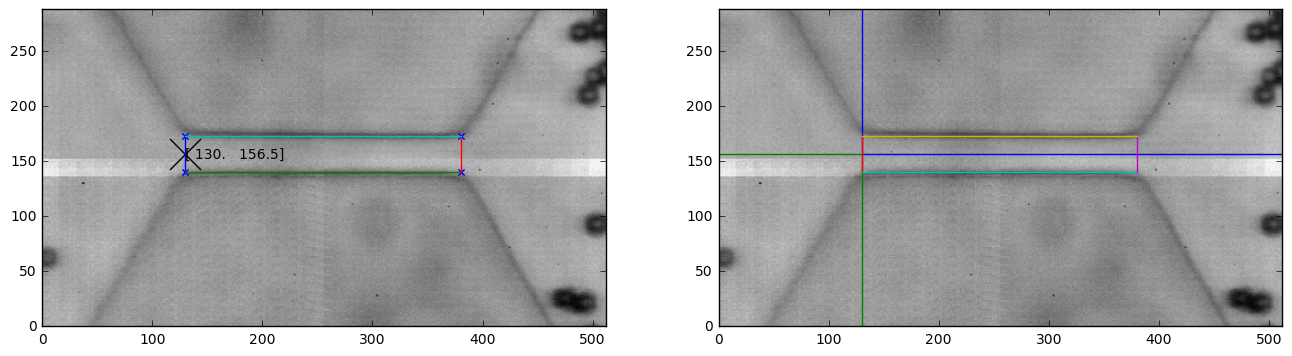

In [4]:
template_frame = oi_vid.get_frame(0)
c0 = [130,173]
c1 = [130,140]
c2 = [380,140]
c3 = [380,173]
stage = oi.Stage(template_frame, c0, c1, c2, c3)

stage.plot_stage()

<a id='3'></a>
### 3. Preprocessing

In [21]:
oi_event = oi_events[0]                  # Look at just one event and one frame from event
detection = oi_event._detections[15]     # Select an arbitrary frame index for a single event
tf = detection._tf

# Select a subset region of the entire frame in the neighborhood of the particle's location...
# No need to analyze the entire frame
ind = [detection._px-30,
       detection._px+30,
       detection._py-30,
       detection._py+30]

# Frame... This is the frame at index frame_tf, clipped down to only have the region of interest
frame = (oi_vid.get_frame(tf))[ind[2]:ind[3],ind[0]:ind[1]]

# Template frame, but also clipped to remove everything besides the region of interest
temp_template_frame = template_frame[ind[2]:ind[3],ind[0]:ind[1]]

# Negative
negative_frame = np.abs(frame - temp_template_frame)

# Threshold
# This turns the image into a binary image, where white pixels represent the location of the particle and
# black pixels show the background; this depends on the threshold parameter below
threshold = 0.03
threshold_frame = 1*negative_frame
threshold_frame[threshold_frame >= threshold] = 1
threshold_frame[threshold_frame < threshold] = 0

# Find clusters in threshold frame; a cluster is a list of connected pixels
clusters_frame = np.zeros(frame.shape, dtype = np.uint8)
clusters = oi.find_clusters_percentage_based(
    threshold_frame, np.zeros((frame.shape[0], frame.shape[1])), cluster_threshold = 10, diag = False)

# Only consider the pixels belonging to the largest cluster; sometimes particles have random 'halos',
# pixels in their vicinity that are lit up, but are not part of the actual particle.
# We want to remove these, in addition to other artifacts
cluster = sorted(clusters, key = lambda x: len(x))[-1]
for pix in cluster:
    clusters_frame[pix[0], pix[1]] = 1


# Binary dilate cluster
# This fills in gaps on the edges of the cluster
clusters_frame = scipy.ndimage.morphology.binary_dilation(clusters_frame, iterations = 1).astype(np.uint8)


# Remove dangling pixels
kernel = np.array([[0, 0, 1], 
                   [0, 1, 1], 
                   [0, 0, 1]])
keep_going = True
mask = np.zeros(clusters_frame.shape, dtype = np.uint8)
mask |= scipy.ndimage.binary_hit_or_miss(clusters_frame, structure1 = kernel)
mask |= scipy.ndimage.binary_hit_or_miss(clusters_frame, structure1 = kernel.T)
mask |= scipy.ndimage.binary_hit_or_miss(clusters_frame, structure1 = np.fliplr(kernel))
mask |= scipy.ndimage.binary_hit_or_miss(clusters_frame, structure1 = np.flipud(kernel))

clusters_frame = clusters_frame & (1-mask)


# Fill holes; holes are defined as connected black pixels that are encompassed by white pixels
clusters_frame = scipy.ndimage.binary_fill_holes(clusters_frame)


# Find edge pixels; this fetches only the pixels that are on the outer border of the processed cluster
edge_pixels = scipy.ndimage.morphology.binary_dilation(clusters_frame, iterations = 1).astype(np.uint8) - clusters_frame
edge_pixels = np.where(edge_pixels == 1)

/home/prestonh/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/prestonh/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


##### Plots to make sure the thresholding is accurate

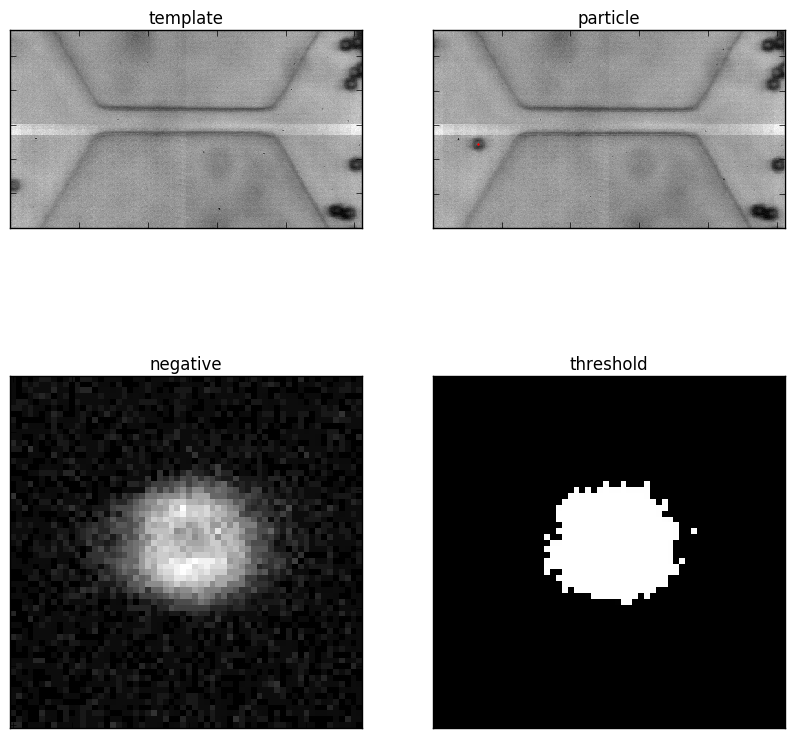

In [22]:
fig, axes = plt.subplots(2,2,figsize = ((10,10)))

# 0    Template plot
plt.sca(axes[0,0])
plt.imshow(template_frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
plt.title('template')
axes[0,0].tick_params(labelbottom='off', labelleft = 'off')    

# 1    Particle image plot
plt.sca(axes[0,1])
plt.imshow(oi_vid.get_frame(tf), cmap = 'gray', origin = 'lower', interpolation = 'none')
plt.scatter(detection._px, detection._py, color = 'red', marker = 'x', s = 1)
plt.title('particle')
plt.xlim(0, template_frame.shape[1])
plt.ylim(0, template_frame.shape[0])
axes[0,1].tick_params(labelbottom='off', labelleft = 'off')

# 2    Negative plot
plt.sca(axes[1,0])
plt.imshow(negative_frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
plt.title('negative')
axes[1,0].tick_params(labelbottom='off', labelleft = 'off')

# 3    Threshold plot
plt.sca(axes[1,1])
plt.imshow(threshold_frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
plt.title('threshold')
axes[1,1].tick_params(labelbottom='off', labelleft = 'off')

plt.show()

<a id='4'></a>
### 4. Fit ellipse

In [23]:
def fit_ellipse(x,y):
    '''
    Source:
    http://nicky.vanforeest.com/misc/fitEllipse/fitEllipse.html
    http://stackoverflow.com/questions/13635528/fit-a-ellipse-in-python-given-a-set-of-points-xi-xi-yi
    '''
    x = x[:,np.newaxis]
    y = y[:,np.newaxis]
    D =  np.hstack((x*x, x*y, y*y, x, y, np.ones_like(x)))
    S = np.dot(D.T,D)
    C = np.zeros([6,6])
    C[0,2] = C[2,0] = 2; C[1,1] = -1
    E, V =  np.linalg.eig(np.dot(np.linalg.inv(S), C))
    n = np.argmax(np.abs(E))
    a = V[:,n]
    return a

def get_ellipse_center(a):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    num = b*b-a*c
    x0=(c*d-b*f)/num
    y0=(a*f-b*d)/num
    return np.array([x0,y0])

def get_ellipse_angle_of_rotation( a ):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    return 0.5*np.arctan(2*b/(a-c))

def get_ellipse_axis_length( a ):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    up = 2*(a*f*f+c*d*d+g*b*b-2*b*d*f-a*c*g)
    down1=(b*b-a*c)*( (c-a)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    down2=(b*b-a*c)*( (a-c)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    res1=np.sqrt(up/down1)
    res2=np.sqrt(up/down2)
    return np.array([res1, res2])

In [24]:
# Fit ellipse to edge pixels
ellipse = fit_ellipse(edge_pixels[0], edge_pixels[1])
ellipse_center = get_ellipse_center(ellipse)
ellipse_angle = get_ellipse_angle_of_rotation(ellipse)
ellipse_axes = get_ellipse_axis_length(ellipse)
ellipse_aspect = ellipse_axes[0]/ellipse_axes[1]
ellipse_area = np.pi*ellipse_axes[0]*ellipse_axes[1]

### 5. Create plots

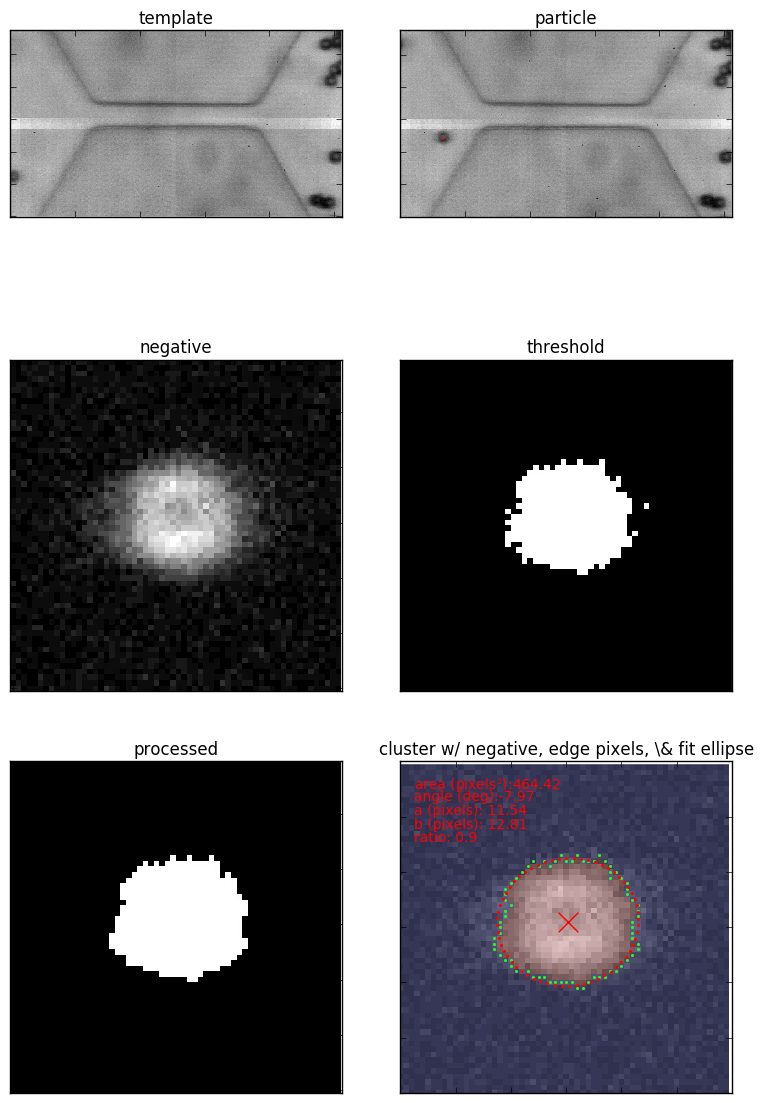

In [30]:
num_points = 60
ellipse_edge_pixels = np.empty((num_points,2))
for i in range(num_points):
    theta = 1.*i/num_points * 2.*np.pi
    x = ellipse_axes[0]*np.cos(theta)
    y = ellipse_axes[1]*np.sin(theta)
    ellipse_edge_pixels[i,0] = ellipse_center[0] + np.cos(ellipse_angle)*x - np.sin(ellipse_angle)*y
    ellipse_edge_pixels[i,1] = ellipse_center[1] + np.sin(ellipse_angle)*x + np.cos(ellipse_angle)*y


ellipse_aspect = ellipse_axes[0]/ellipse_axes[1]
ellipse_area = np.pi*ellipse_axes[0]*ellipse_axes[1]


fig, axes = plt.subplots(3,2, figsize = (8,12))

# 0    Template plot
plt.sca(axes[0,0])
plt.imshow(template_frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
plt.title('template')
axes[0,0].tick_params(labelbottom='off', labelleft = 'off')    

# 1    Particle image plot
plt.sca(axes[0,1])
plt.imshow(oi_vid.get_frame(tf), cmap = 'gray', origin = 'lower', interpolation = 'none')
plt.scatter(detection._px, detection._py, color = 'red', marker = 'x', s = 1)
plt.title('particle')
plt.xlim(0, template_frame.shape[1])
plt.ylim(0, template_frame.shape[0])
axes[0,1].tick_params(labelbottom='off', labelleft = 'off')

# 2    Negative plot
plt.sca(axes[1,0])
plt.imshow(negative_frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
plt.title('negative')
axes[1,0].tick_params(labelbottom='off', labelleft = 'off')

# 3    Threshold plot
plt.sca(axes[1,1])
plt.imshow(threshold_frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
plt.title('threshold')
axes[1,1].tick_params(labelbottom='off', labelleft = 'off')

# 4    Cluster
plt.sca(axes[2,0])
plt.imshow(clusters_frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
plt.title('processed')
axes[2,0].tick_params(labelbottom='off', labelleft = 'off')


# 5    Particle edge plot
plt.sca(axes[2,1])

plt.imshow(negative_frame, cmap = 'gray', origin = 'lower', alpha = .75, interpolation = 'none')
plt.imshow(clusters_frame, origin = 'lower', alpha = 0.25, interpolation = 'none')
plt.scatter(edge_pixels[1], edge_pixels[0], marker = '.', lw = 0, c = np.array([48,239,48])/255.)
plt.scatter(ellipse_center[1], ellipse_center[0], marker = 'x', c = 'red', s = 200)
plt.scatter(ellipse_edge_pixels[:,1], ellipse_edge_pixels[:,0], marker = '.', lw = 0, c = 'red')#c = np.array([247,239,140])/255.)

# Text
plt.text(2.5, 57.5, 'area (pixels$^{2}$):' + str(round(ellipse_area,2)), color = 'red', ha = 'left', va = 'top')
plt.text(2.5, 55, 'angle (deg):' + str(round(ellipse_angle*180/np.pi,2)), color = 'red', ha = 'left', va = 'top')
plt.text(2.5, 52.5, 'a (pixels): ' + str(round(ellipse_axes[0],2)), color = 'red', ha = 'left', va = 'top')
plt.text(2.5, 50, 'b (pixels): ' + str(round(ellipse_axes[1],2)), color = 'red', ha = 'left', va = 'top')
plt.text(2.5, 47.5, 'ratio: ' + str(round(ellipse_axes[0]/ellipse_axes[1], 2)), color = 'red', ha = 'left', va = 'top')
plt.xlim(0, negative_frame.shape[0])
plt.ylim(0, negative_frame.shape[1])
axes[2,1].tick_params(labelbottom='off', labelleft = 'off')
plt.title('cluster w/ negative, edge pixels, \& fit ellipse')

fig.tight_layout()

#plt.savefig('cell_ellipse_fit_' + str(event_num) + '_' + str(det_ind) + '.png', dpi = 300)

plt.show()